In [1]:
## Resize images to 224 px

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Load the MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [4]:
# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=predictions)



In [6]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Prepare the data
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'Model_input/resized_dataset_224/Dataset_train_224',  # Make sure your resized data is here for training
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'Model_input/resized_dataset_224/Dataset_train_224',  # Make sure your resized training data is here for training
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 31702 images belonging to 2 classes.
Found 7925 images belonging to 2 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'Model_input/resized_dataset_224/Dataset_test_224',  # Make sure your resized testing data is here for testing
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for matching predictions with true labels
)

Found 17078 images belonging to 2 classes.


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,          # Wait 10 epochs after the last improvement ideally.
        min_delta=0.001,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,          # Reduce learning rate by 10x
        patience=3,          # Wait 5 epochs before reducing LR ideally
        min_lr=1e-6          # Minimum learning rate
    )
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,              # Large number (early stopping will handle it). For testing, use 5 epochs
    callbacks=callbacks
)

Epoch 1/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 385s 389ms/step - accuracy: 0.9711 - loss: 0.0887 - val_accuracy: 0.7471 - val_loss: 0.8384 - learning_rate: 0.0010
Epoch 2/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 234s 236ms/step - accuracy: 0.9891 - loss: 0.0322 - val_accuracy: 0.7350 - val_loss: 0.8697 - learning_rate: 0.0010
Epoch 3/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 236s 238ms/step - accuracy: 0.9910 - loss: 0.0275 - val_accuracy: 0.7365 - val_loss: 1.0176 - learning_rate: 0.0010
Epoch 4/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 237s 239ms/step - accuracy: 0.9935 - loss: 0.0191 - val_accuracy: 0.7187 - val_loss: 1.1566 - learning_rate: 0.0010
Epoch 5/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 240s 242ms/step - accuracy: 0.9969 - loss: 0.0114 - val_accuracy: 0.7122 - val_loss: 1.1534 - learning_rate: 1.0000e-04
Epoch 6/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 244s 246ms/step - accuracy: 0.9981 - loss: 0.0077 - val_accuracy: 0.7062 - val_loss: 1.1931 - learning_rate: 1.0000e-04
Epoch 7/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 241s 244ms/step 

In [18]:
## Code Only for retraining Model al layers at a lower learning rate

# 2. Unfreeze all layers for fine-tuning
for layer in model.layers:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Continue training with unfrozen layers
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,              # Can use more epochs since learning rate is small
    initial_epoch=history.epoch[-1] + 1,  # Start from next epoch
    callbacks=callbacks
)

Epoch 12/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 1138s 1s/step - accuracy: 0.9022 - loss: 0.5323 - val_accuracy: 0.8733 - val_loss: 0.3727 - learning_rate: 1.0000e-05
Epoch 13/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 1169s 1s/step - accuracy: 0.9907 - loss: 0.0269 - val_accuracy: 0.9365 - val_loss: 0.2039 - learning_rate: 1.0000e-05
Epoch 14/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 1186s 1s/step - accuracy: 0.9959 - loss: 0.0135 - val_accuracy: 0.9200 - val_loss: 0.3141 - learning_rate: 1.0000e-05
Epoch 15/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 1198s 1s/step - accuracy: 0.9970 - loss: 0.0090 - val_accuracy: 0.9051 - val_loss: 0.4027 - learning_rate: 1.0000e-05
Epoch 16/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 1212s 1s/step - accuracy: 0.9969 - loss: 0.0103 - val_accuracy: 0.9055 - val_loss: 0.3855 - learning_rate: 1.0000e-05
Epoch 17/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 1211s 1s/step - accuracy: 0.9981 - loss: 0.0050 - val_accuracy: 0.9003 - val_loss: 0.4229 - learning_rate: 1.0000e-06
Epoch 18/50
991/991 ━━━━━━━━━━━━━━━━━━━━ 1112s

534/534 ━━━━━━━━━━━━━━━━━━━━ 93s 173ms/step


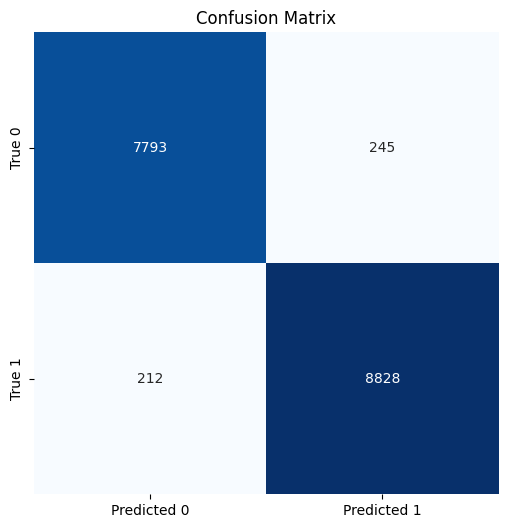

              precision    recall  f1-score      support
Class 0        0.973517  0.969520  0.971514   8038.00000
Class 1        0.972997  0.976549  0.974770   9040.00000
accuracy       0.973240  0.973240  0.973240      0.97324
macro avg      0.973257  0.973034  0.973142  17078.00000
weighted avg   0.973241  0.973240  0.973237  17078.00000
Classification report saved to 'classification_report_MobilenetV2_step2_training.csv'


In [21]:
# RUN ONLY AFTER CLASSIFICATION REPORT COMPONENT IS ADDED AT THE BOTTOM
# Combine histories if you want to plot them later
import pandas as pd
total_history = {
    'accuracy': history.history['accuracy'] + fine_tune_history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'],
    'loss': history.history['loss'] + fine_tune_history.history['loss'],
    'val_loss': history.history['val_loss'] + fine_tune_history.history['val_loss']
}
## Add steps for geerating classification report
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Updated now for 30/70 test/train split
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])

plt.title('Confusion Matrix')
plt.show()

# Generating a classification report
report_dict = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

report_df = pd.DataFrame(report_dict).transpose()
print(report_df)

# Save classification report to CSV
report_df.to_csv("classification_report_MobilenetV2_step2_training.csv", index=True)
print("Classification report saved to 'classification_report_MobilenetV2_step2_training.csv'")

In [27]:
## Below Code is for error analysis
import numpy as np
import random
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Get filenames in same order as y_true / y_pred
file_paths = test_generator.filepaths
misclassified_indices = np.where(y_true != y_pred)[0]

# Separate misclassified indices by actual class
misclassified_class_0 = [i for i in misclassified_indices if y_true[i] == 0]
misclassified_class_1 = [i for i in misclassified_indices if y_true[i] == 1]

# Pick 20 random examples from each class (or fewer if not enough)
sampled_0 = random.sample(misclassified_class_0, min(20, len(misclassified_class_0)))
sampled_1 = random.sample(misclassified_class_1, min(20, len(misclassified_class_1)))
sampled_indices = sampled_0 + sampled_1

from PIL import Image  # Already needed

# Create base output directories
base_output_dir = 'misclassified_images_Mobilenet_with_labels'
class_0_dir = os.path.join(base_output_dir, 'class_0')
class_1_dir = os.path.join(base_output_dir, 'class_1')
os.makedirs(class_0_dir, exist_ok=True)
os.makedirs(class_1_dir, exist_ok=True)

# Save misclassified images to respective class folders
for mis_idx in sampled_indices:
    img_path = file_paths[mis_idx]
    img = Image.open(img_path).resize((224, 224))

    true_label = y_true[mis_idx]
    pred_label = y_pred[mis_idx]

    # Choose folder based on true label
    save_dir = class_0_dir if true_label == 0 else class_1_dir

    original_filename = os.path.basename(img_path)
    save_filename = f"T{true_label}_P{pred_label}_{original_filename}"
    save_path = os.path.join(save_dir, save_filename)
    img.save(save_path)




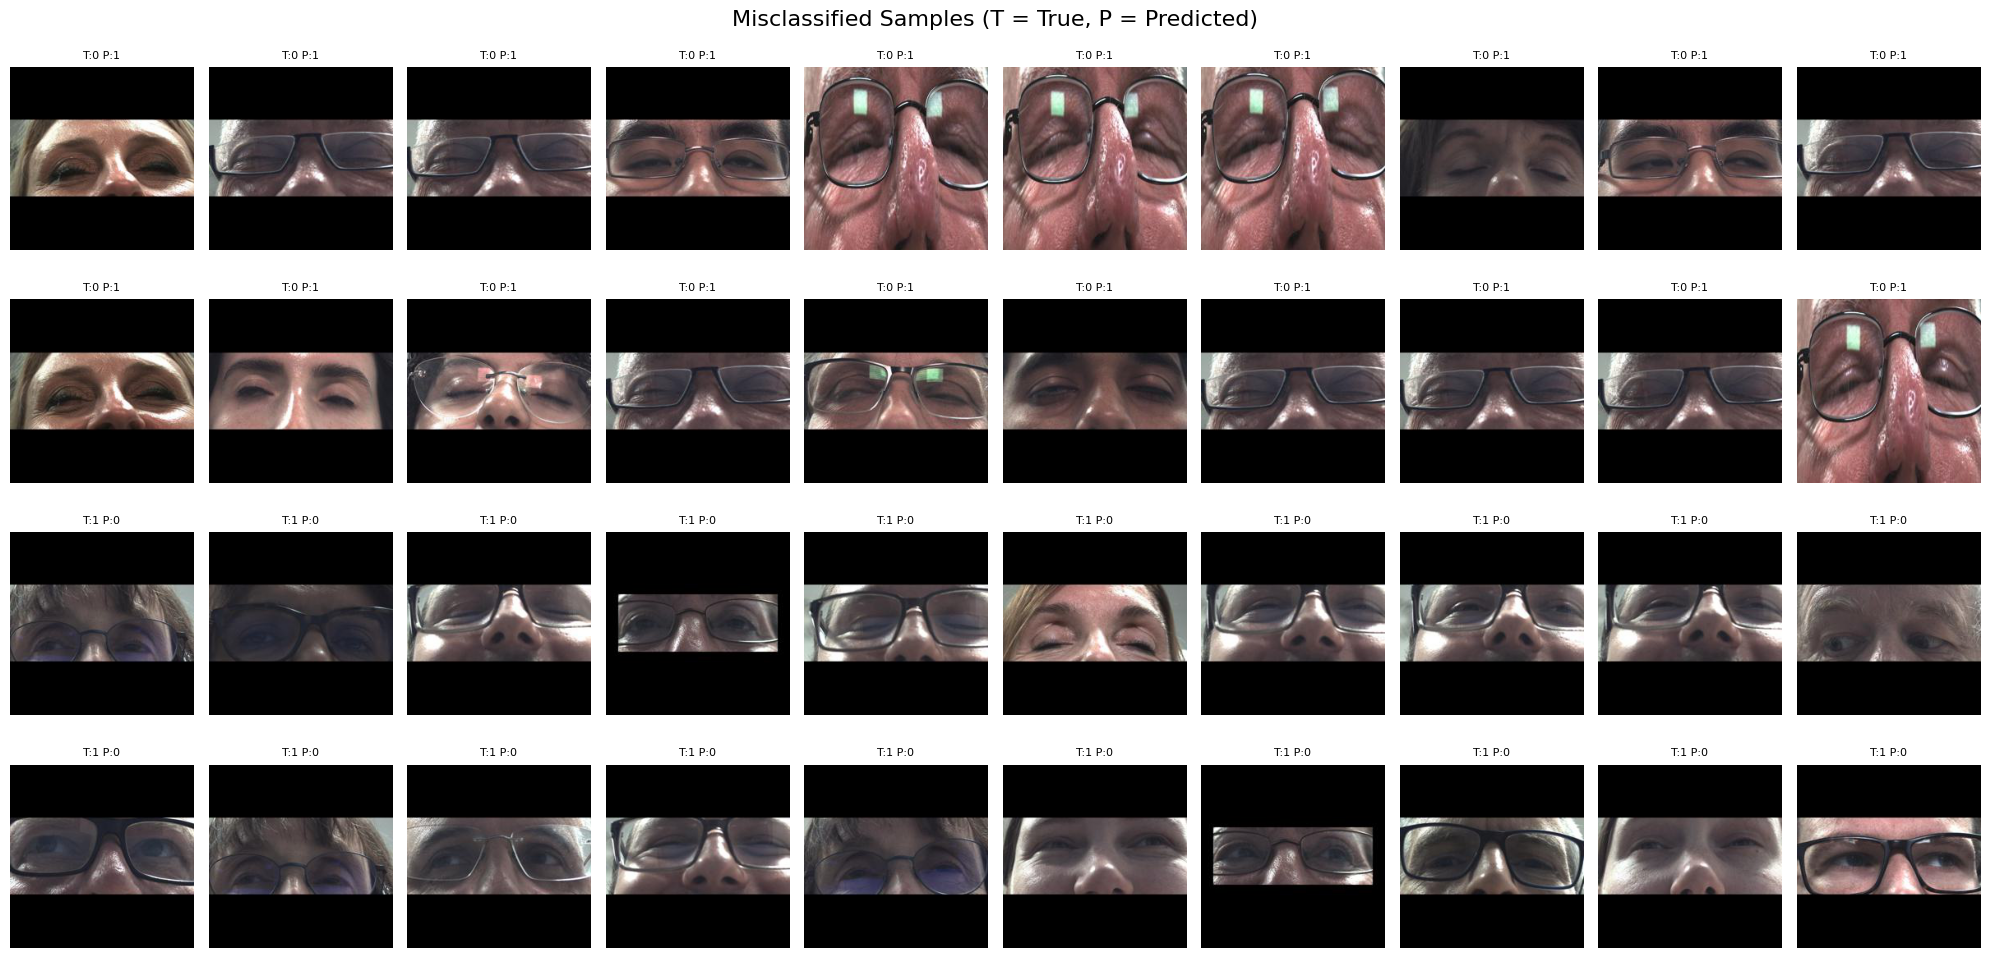

In [25]:
# Plotting misclassified images
plt.figure(figsize=(20, 10))
for idx, mis_idx in enumerate(sampled_indices):
    img_path = file_paths[mis_idx]
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(4, 10, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"T:{y_true[mis_idx]} P:{y_pred[mis_idx]}", fontsize=8)
plt.suptitle("Misclassified Samples (T = True, P = Predicted)", fontsize=16)
plt.tight_layout()
plt.show()

In [31]:
import csv
import os

# Directory to save the CSV
output_dir = 'misclassified_images_Mobilenet_with_labels'
os.makedirs(output_dir, exist_ok=True)

# Get all misclassified indices
misclassified_indices = np.where(y_true != y_pred)[0]

# Create CSV data: [original_filename, true_label, predicted_label]
csv_rows = []
for mis_idx in misclassified_indices:
    img_path = file_paths[mis_idx]
    original_filename = os.path.basename(img_path)
    true_label = y_true[mis_idx]
    pred_label = y_pred[mis_idx]
    csv_rows.append([original_filename, true_label, pred_label])

# Write to CSV
csv_path = os.path.join(output_dir, 'all_misclassified.csv')
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['filename', 'true_label', 'predicted_label'])
    writer.writerows(csv_rows)



/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


534/534 ━━━━━━━━━━━━━━━━━━━━ 99s 185ms/step


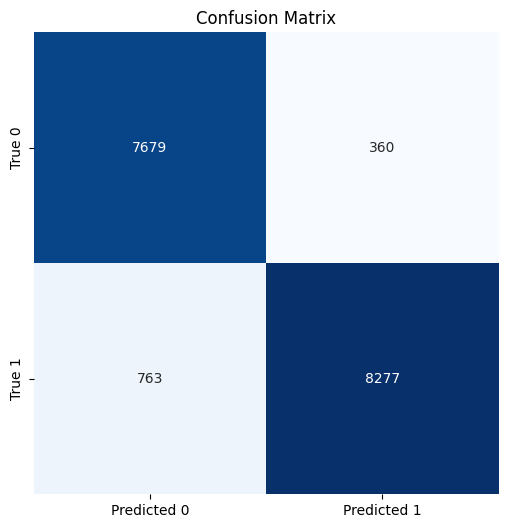

In [16]:
## True labels and predictions. Used earlier when entire data was utilized for training. Below block represents model after step 1 traininf
# y_true = val_generator.classes
# y_pred_probs = model.predict(val_generator).flatten()  # Flatten for binary
# y_pred = (y_pred_probs > 0.5).astype(int)  # Threshold at 0.5
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Updated now for 30/70 test/train split
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])

plt.title('Confusion Matrix')
plt.show()

# Generating a classification report
report_dict = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

In [18]:
import pandas as pd
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)

# Save classification report to CSV
report_df.to_csv("classification_report_MobilenetV2.csv", index=True)
print("Classification report saved to 'classification_report_MobilenetV2_11_epochs_10pm.csv'")

              precision    recall  f1-score       support
Class 0        0.909619  0.955218  0.931861   8039.000000
Class 1        0.958319  0.915597  0.936471   9040.000000
accuracy       0.934247  0.934247  0.934247      0.934247
macro avg      0.933969  0.935408  0.934166  17079.000000
weighted avg   0.935396  0.934247  0.934301  17079.000000
Classification report saved to 'classification_report_MobilenetV2_11_epochs_10pm.csv'
